In [43]:
# Image type matrix completion
# Loss fixed points
import csv
from collections import namedtuple
import enum
from MinPy import demo, loss as lossm, net, reg
import torch
from MinPy.toolbox import dataloader, plot, pprint
import numpy as np


device = 'cuda' if torch.cuda.is_available() else 'cpu'


rng = np.random.RandomState(seed=20210909)

Shape = namedtuple('Shape', ['rows', 'cols'])
Regularizer = namedtuple('RegularizerSet', ['weight_decay', 'regularizer', 'optimizer'])


def csv_to_tensor(csv_path):
    with open(csv_path) as f:
        reader = csv.reader(f, delimiter=',')
        rows = []
        for row in reader:
            rows.append([float(f) for f in row])
    return torch.tensor(rows)


def train_my_dmf(matrix_dimensions, loss_fn, model_optimizer, matrix, mask, epochs):
    model = net.MyDeepMatrixFactorization(matrix_dimensions).to(device)
    model_optimizer = model_optimizer(model.parameters())
    model.train()

    nmae_losses = []
    for e in range(epochs):

        # Compute prediction error
        reconstructed_matrix = model(matrix * mask)
        loss = loss_fn(reconstructed_matrix, matrix, mask)

        # Backpropagation
        model_optimizer.zero_grad()
        loss.backward()
        model_optimizer.step()

        nmae_losses.append(lossm.nmae(reconstructed_matrix, matrix, mask).detach().cpu().numpy())

        if e % 100 == 0:
            pprint.my_progress_bar(e, epochs, nmae_losses[-1])
        if e % 5000 == 0:
            plot.gray_im(reconstructed_matrix.cpu().detach().numpy())

    return reconstructed_matrix, nmae_losses


def train_my_dmf_air(matrix_dimensions, loss_fn, model_optimizer, matrix, mask, epochs,
                     row_similarity_optimizer=None, col_similarity_optimizer=None):
    model = net.MyDeepMatrixFactorization(matrix_dimensions).to(device)
    model_optimizer = model_optimizer(model.parameters())
    model.train()
    height, width = matrix.shape

    RegularizerSet = namedtuple('RegularizerSet', ['weight_decay', 'regularizer', 'optimizer'])
    regularizer_list = []

    if row_similarity_optimizer:
        regularizer = reg.DirichletEnergyRegularization(height, reg.DirichletEnergyRegularizationMode.ROW_SIMILARITY).to(device)
        optimizer = row_similarity_optimizer(regularizer.parameters())
        regularizer_list.append(RegularizerSet(weight_decay=1e-4, regularizer=regularizer, optimizer=optimizer))

    if col_similarity_optimizer:
        regularizer = reg.DirichletEnergyRegularization(width, reg.DirichletEnergyRegularizationMode.COL_SIMILARITY).to(device)
        optimizer = col_similarity_optimizer(regularizer.parameters())
        regularizer_list.append(RegularizerSet(weight_decay=1e-4, regularizer=regularizer, optimizer=optimizer))

    nmae_losses = []
    for e in range(epochs):

        # Compute prediction error
        reconstructed_matrix = model(matrix * mask)
        loss = (
            loss_fn(reconstructed_matrix, matrix, mask)
            + sum(r.weight_decay * r.regularizer(reconstructed_matrix) for r in regularizer_list)
        )

        # Backpropagation
        model_optimizer.zero_grad()
        for r in regularizer_list:
            r.optimizer.zero_grad()

        loss.backward()

        model_optimizer.step()
        for r in regularizer_list:
            r.optimizer.step()

        nmae_losses.append(lossm.nmae(reconstructed_matrix, matrix, mask).detach().cpu().numpy())

        if e % 100 == 0:
            pprint.my_progress_bar(e, epochs, nmae_losses[-1])
        if e % 5000 == 0:
            plot.gray_im(reconstructed_matrix.cpu().detach().numpy())

    return reconstructed_matrix, nmae_losses


def train_dmf_air(matrix_dimensions, matrix, mask, epochs):
    height, width = matrix.shape
    reg_row = reg.auto_reg(height, 'row')
    reg_col = reg.auto_reg(width, 'col')
    regularizers = [reg_row, reg_col]
    dmf = demo.BasicDeepMatrixFactorization(matrix_dimensions, regularizers) # Define model

    eta = [1e-4, 1e-4]

    #Training model
    for ite in range(epochs):
        dmf.train(matrix, mu=1, eta=eta, mask_in=mask)

        if ite % 100 == 0:
            pprint.progress_bar(ite, epochs, dmf.loss_dict) # Format the loss of the output training and print out the training progress bar

        if ite % 5000 == 0:
            plot.gray_im(dmf.net.data.cpu().detach().numpy()) # Display the training image, you can set parameters to save the image

    return dmf.net.data, dmf.loss_dict['nmae_test']


def write_csv(matrix, filename):
    np.savetxt(f'{filename}.csv', matrix, delimiter=',')


def drive(miss_mode, image_path, mask_path):
    height = 240
    width = 49
    epochs = 15_001
    rng = np.random.RandomState(seed=20210909)
    row_indices = rng.permutation(height)
    print(row_indices)
    pic = csv_to_tensor(image_path)[row_indices].cuda()
    # pic = dataloader.get_data(height=height,width=width,pic_name=image_path).cuda() # Read grayscale image

    plot.gray_im(pic.cpu()) # Display grayscale image

    transformer = dataloader.data_transform(z=pic,return_type='tensor')

    if miss_mode is MissMode.RANDOM:
        mask_in = transformer.get_drop_mask(rate=0.9) # 'rate' is the loss rate
        mask_in[mask_in < 1] = 0
    elif miss_mode is MissMode.PATCH:
        mask_in = torch.ones(height, width).cuda()
        mask_in[70:100, 150:190] = 0
        mask_in[200:230, 200:230] = 0
    elif miss_mode is MissMode.FIXED:
        mask_in = dataloader.get_data(height=height, width=width, pic_name=mask_path)
        mask_in[mask_in < 1] = 0
    else:
        raise ValueError(f'Invalid MissMode: {miss_mode.name}')

    plot.gray_im(pic.cpu() * mask_in.cpu())

    matrix_dimensions = [
        (height, height),
        (height, height),
        (height, width)
    ]
    line_dict = {'x_plot': np.arange(0, epochs, 1)}
    RCMatrix_MyDMF, line_dict['mydmf'] = train_my_dmf(
        matrix_dimensions,
        lossm.mse,
        torch.optim.Adam,
        pic,
        mask_in.cuda(),
        epochs
    )
    RCMatrix_MyDMF_AIR, line_dict['mydmfair'] = train_my_dmf_air(
        matrix_dimensions,
        lossm.mse,
        torch.optim.Adam,
        pic,
        mask_in.cuda(),
        epochs,
        row_similarity_optimizer=torch.optim.Adam,
        col_similarity_optimizer=torch.optim.Adam
    )
#     RCMatrix_DMF_AIR, line_dict['DMF+AIR'] = train_dmf_air(matrix_dimensions, pic, mask_in.cuda(), epochs)

#     write_csv(row_indices.reshape(-1, 1), 'row_indices')
#     write_csv(RCMatrix_MyDMF.cpu().detach().numpy(), 'RCMatrix_MyDMF')
#     write_csv(RCMatrix_MyDMF_AIR.cpu().detach().numpy(), 'RCMatrix_MyDMF_AIR')
#     write_csv(RCMatrix_DMF_AIR.cpu().detach().numpy(), 'RCMatrix_DMF_AIR')

    plot.lines(line_dict, save_if=False, black_if=True, ylabel_name='NMAE')
    
def get_bit_mask(matrix, rate):
    return torch.tensor(rng.random(matrix.shape) > rate).int().to(device)
    
def dirichlet_energy_regularization(weight_decay, dimension, similarity_type):
    regularizer = reg.DirichletEnergyRegularization(dimension, similarity_type).to(device)
    optimizer = torch.optim.Adam(regularizer.parameters())
    return Regularizer(weight_decay=weight_decay, regularizer=regularizer, optimizer=optimizer)


def paper_regularization(weight_decay, dimension, similarity_type):
    regularizer = reg.auto_reg(dimension, similarity_type)
    return Regularizer(weight_decay=weight_decay, regularizer=regularizer, optimizer=None)


def run_test(epochs, matrix_factor_dimensions, matrix, mask, regularizers=None):
    if not regularizers:
        regularizers = []

    model = net.MyDeepMatrixFactorization(matrix_factor_dimensions).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    model.train()
    height, width = matrix.shape

    nmae_losses = []
    for e in range(epochs):

        # Compute prediction error
        reconstructed_matrix = model(matrix * mask)
        loss = (
            lossm.mse(reconstructed_matrix, matrix, mask)
            + sum((r.weight_decay * r.regularizer(reconstructed_matrix) for r in regularizers), start=0)
        )

        # Backpropagation
        optimizer.zero_grad()
        for r in regularizers:
            r.optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        for r in regularizers:
            r.optimizer.step()

        nmae_losses.append(lossm.nmae(reconstructed_matrix, matrix, mask).detach().cpu().numpy())

        if e % 100 == 0:
            pprint.my_progress_bar(e, epochs, nmae_losses[-1])
        if e % 5000 == 0:
            plot.gray_im(reconstructed_matrix.cpu().detach().numpy())

    return reconstructed_matrix, nmae_losses


def run_paper_test(epochs, matrix_factor_dimensions, matrix, mask, regularizers=None):
    if not regularizers:
        regularizers = []

    dmf = demo.BasicDeepMatrixFactorization(matrix_factor_dimensions, [r.regularizer for r in regularizers]) # Define model

    eta = [r.weight_decay for r in regularizers]

    #Training model
    for ite in range(epochs):
        dmf.train(matrix, mu=1, eta=eta, mask_in=mask)

        if ite % 100 == 0:
            pprint.my_progress_bar(e, epochs, nmae_losses[-1])
            pprint.progress_bar(ite, epochs, dmf.loss_dict) # Format the loss of the output training and print out the training progress bar

        if ite % 5000 == 0:
            plot.gray_im(dmf.net.data.cpu().detach().numpy()) # Display the training image, you can set parameters to save the image

    return dmf.net.data, dmf.loss_dict['nmae_test']
    


loss_fid:2e+02,nmae_test:0.17, loss_all:2e+02. Trainning progress: 0.0 %:  

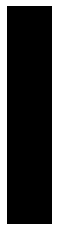

loss_fid:1.7,nmae_test:0.02, loss_all:4.8. Trainning progress: 50.0 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

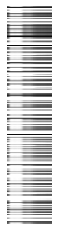

loss_fid:0.13,nmae_test:0.0069, loss_all:0.42. Trainning progress: 1e+02 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

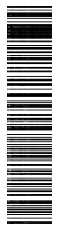

loss: 0.17. Trainning progress: 0.0%:  

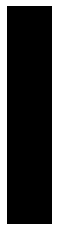

loss: 0.0087. Trainning progress: 50.0%:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

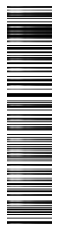

loss: 0.0017. Trainning progress: 1e+02%:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

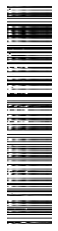

loss: 0.17. Trainning progress: 0.0%:  

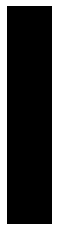

loss: 0.0087. Trainning progress: 29.0%:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋

In [ ]:
stacked_velocity_data = csv_to_tensor('./amir/vel_2Daneu_crop.csv')
row_indices = rng.permutation(240)
matrix = stacked_velocity_data[row_indices].to(device)
mask = get_bit_mask(matrix, rate=0.6)
rows, cols = matrix.shape
matrix_factor_dimensions = [
    Shape(rows=rows, cols=rows),
    Shape(rows=rows, cols=rows),
    Shape(rows=rows, cols=cols)
]
epochs = 10_001
RCMatrix_PaperDMFAIR, PaperDMFAIR_losses = run_paper_test(epochs, matrix_factor_dimensions, matrix, mask, regularizers=[
    paper_regularization(1e-4, rows, 'row'),
    paper_regularization(1e-4, cols, 'col')
])
RCMatrix_MyDMF, MyDMF_losses = run_test(epochs, matrix_factor_dimensions, matrix, mask)
RCMatrix_MyDMFAIR, MyDMFAIR_losses = run_test(epochs, matrix_factor_dimensions, matrix, mask, regularizers=[
    dirichlet_energy_regularization(1e-4, rows, reg.DirichletEnergyRegularizationMode.ROW_SIMILARITY),
    dirichlet_energy_regularization(1e-4, cols, reg.DirichletEnergyRegularizationMode.COL_SIMILARITY)
])
plot.lines({'x_plot': np.arange(0, epochs, 1),
            'MyDMF': MyDMF_losses,
            'MyDMFAIR': MyDMFAIR_losses,
            'PaperDMFAIR': PaperDMFAIR_losses}, save_if=False, black_if=True, ylabel_name='NMAE')

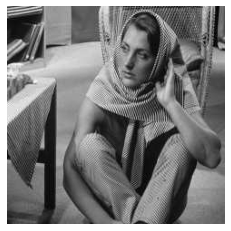

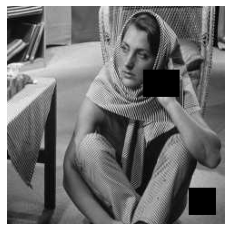

loss_fid:0.22,nmae_test:0.43, loss_all:0.22. Trainning progress: 0.0 %:  

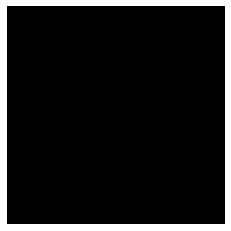

RMSE: 0.4783331
loss_fid:0.0015,nmae_test:0.39, loss_all:0.0015. Trainning progress: 50.0 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

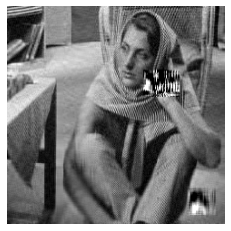

RMSE: 0.10784427
loss_fid:9.4e-05,nmae_test:0.74, loss_all:9.4e-05. Trainning progress: 1e+02 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

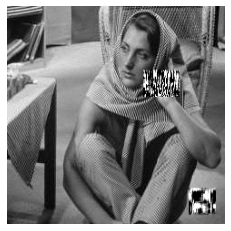

RMSE: 0.19012024
loss_fid:0.22,nmae_test:0.43, loss_all:0.22. Trainning progress: 0.0 %:  

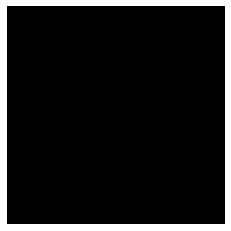

RMSE: 0.47833106
loss_fid:0.01,nmae_test:0.14, loss_all:0.016. Trainning progress: 50.0 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

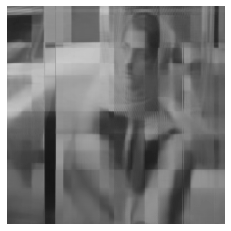

RMSE: 0.10666221
loss_fid:0.00045,nmae_test:0.12, loss_all:0.0011. Trainning progress: 1e+02 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

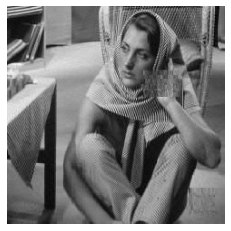

RMSE: 0.036475033


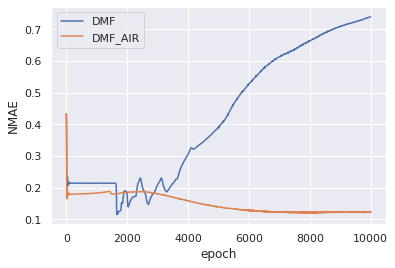

In [17]:
drive(MissMode.PATCH, './train_pics/Barbara.jpg', './masks/mask.png')

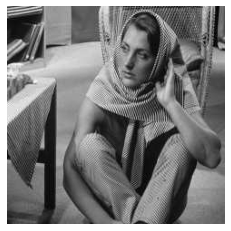

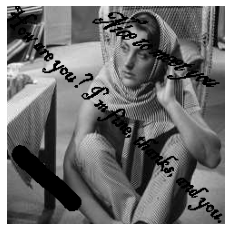

loss_fid:0.21,nmae_test:0.39, loss_all:0.21. Trainning progress: 0.0 %:  

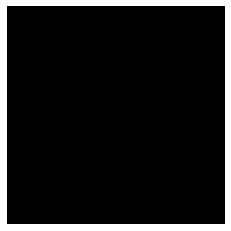

RMSE: 0.47833306
loss_fid:0.0013,nmae_test:0.19, loss_all:0.0013. Trainning progress: 50.0 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

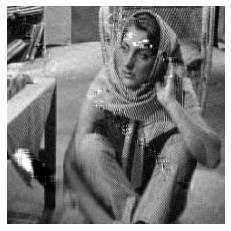

RMSE: 0.104465306
loss_fid:5.9e-05,nmae_test:0.38, loss_all:5.9e-05. Trainning progress: 1e+02 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

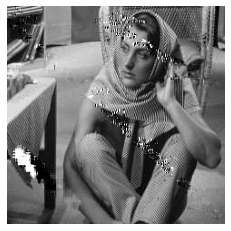

RMSE: 0.21463026
loss_fid:0.21,nmae_test:0.39, loss_all:0.21. Trainning progress: 0.0 %:  

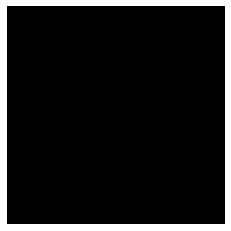

RMSE: 0.4783339
loss_fid:0.01,nmae_test:0.12, loss_all:0.015. Trainning progress: 50.0 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

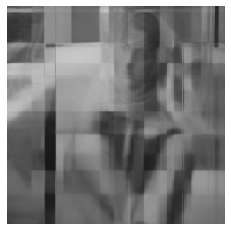

RMSE: 0.11012201
loss_fid:0.00042,nmae_test:0.071, loss_all:0.001. Trainning progress: 1e+02 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

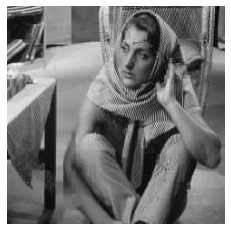

RMSE: 0.037265874


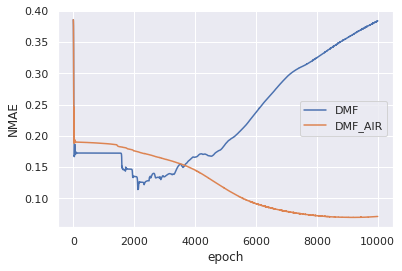

In [18]:
drive(MissMode.FIXED, './train_pics/Barbara.jpg', './masks/mask.png')